In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pandeia_coronagraphy import scene, analysis, transformations, engine

from copy import deepcopy
import numpy as np

# Occulted and Unocculted PSFs

We'll start by running two calculations of the same star: occulted and unocculted by the coronagraph mask.

(0, 1.5)

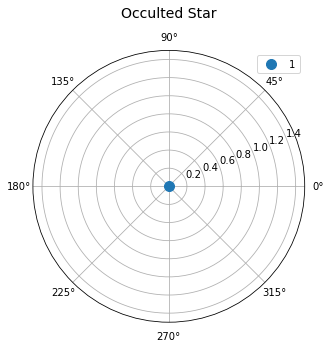

In [2]:
occulted = scene.load_calculation('../templates/nircam_coronagraphy_template.json')

#set instrument parameters
occulted['configuration']['instrument']['aperture'] = 'mask210r'
occulted['configuration']['instrument']['filter'] = 'f210m'
occulted['configuration']['detector']['ngroup'] = 20

#set star properties
occstar = occulted['scene'][0]
occstar['spectrum']['normalization']['bandpass'] = 'johnson,v'
occstar['spectrum']['normalization']['norm_flux'] = 10.
occstar['spectrum']['sed']['key'] = 'a5v'

# and a unique TA error
errx, erry = scene.get_ta_error()
scene.offset_scene(occulted['scene'],errx,erry)

#and plot
scene.plot_scene(occulted['scene'],'Occulted Star')
ax = plt.gca()
ax.set_rlim(0,1.5)

And now the unocculted star, which is identical to the occulted star, but with an offset applied to move it out from under the mask. Since we just need this as a normalization for the contrast calculation, we'll also disable saturation.

(0, 1.5)

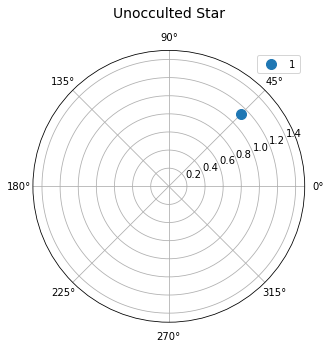

In [3]:
#copy the occulted calculation file
unocculted = deepcopy(occulted)
#apply an offset
unocculted['scene'][0]['position']['x_offset'] = 0.8 #arcsec
unocculted['scene'][0]['position']['y_offset'] = 0.8 #arcsec

unocculted['calculation']['effects']['saturation'] = False #disable saturation

#and plot
scene.plot_scene(unocculted['scene'],'Unocculted Star')
ax = plt.gca()
ax.set_rlim(0,1.5)

And a reference star as well:

(0, 1.5)

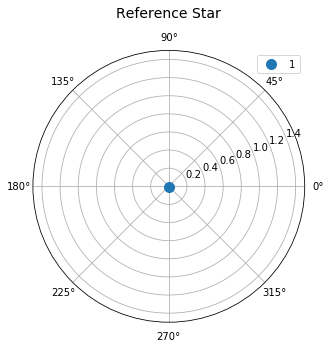

In [4]:
reference = deepcopy(occulted)

# we adopt a brighter but spectrally-mismatched reference
refstar = reference['scene'][0]
refstar['spectrum']['normalization']['bandpass'] = 'johnson,v'
refstar['spectrum']['normalization']['norm_flux'] = 9.
refstar['spectrum']['sed']['key'] = 'a3v'
refstar['position']['x_offset'] = 0. #reset the offset to avoid stacking TA errors
refstar['position']['y_offset'] = 0.

# and a unique TA error
errx_ref, erry_ref = scene.get_ta_error()
scene.offset_scene(reference['scene'],errx_ref,erry_ref)

scene.plot_scene(reference['scene'],'Reference Star')
ax = plt.gca()
ax.set_rlim(0,1.5)

# Run the Pandeia Engine

In [5]:
engine.wave_sampling = 20
occ_results, unocc_results, ref_results = scene.calculate_batch([occulted,unocculted,reference])

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


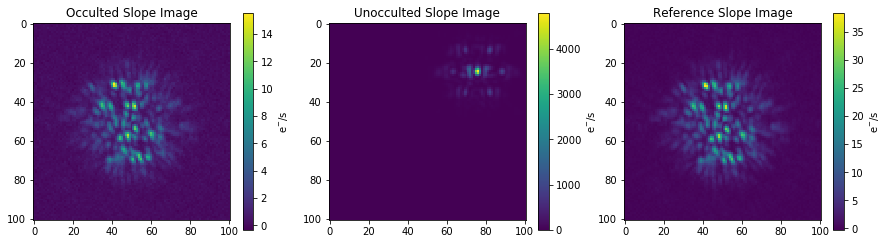

In [6]:
occ_slope = occ_results['2d']['detector']
unocc_slope = unocc_results['2d']['detector']
ref_slope = ref_results['2d']['detector']

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(occ_slope)
plt.title('Occulted Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(unocc_slope)
plt.title('Unocculted Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(ref_slope)
plt.title('Reference Slope Image')
plt.colorbar().set_label('e$^{-}$/s')

# Contrast Calculation

Swap in your favorite contrast calculation here! What follows is a quick and not-so-rigorous approach.

In [7]:
#register the reference to the occulted target for subtraction
centered_occ = occ_slope - np.nanmean(occ_slope)
centered_ref = ref_slope - np.nanmean(ref_slope)
reg_ref = analysis.register_to_target(centered_ref,centered_occ)
ref_sub = centered_occ - reg_ref

In [8]:
# convolve the unocculted image with an aperture and pick out the max 
# as the normalization constant
from scipy.signal import fftconvolve
kernel = np.array([[0,0,1,0,0], #simple aperture
                   [0,1,1,1,0],
                   [1,1,1,1,1],
                   [0,1,1,1,0],
                   [0,0,1,0,0]]).astype(float)
unocc_aperture = fftconvolve(unocc_slope,kernel)
norm = np.max(unocc_aperture)

#convolve reference-subtract and raw frames with the aperture as well
refsub_aperture = fftconvolve(ref_sub,kernel)
occ_aperture = fftconvolve(centered_occ,kernel)

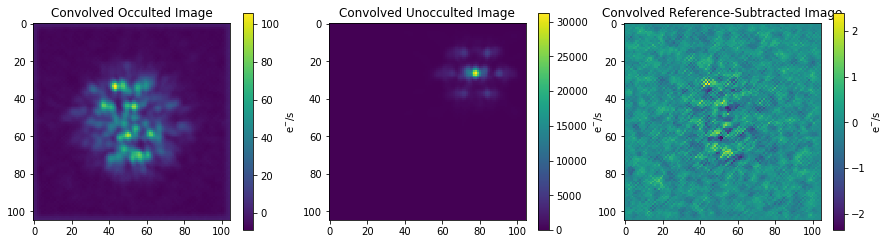

In [9]:
#plot
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(occ_aperture)
plt.title('Convolved Occulted Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(unocc_aperture)
plt.title('Convolved Unocculted Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(refsub_aperture)
plt.title('Convolved Reference-Subtracted Image')
plt.colorbar().set_label('e$^{-}$/s')

In [10]:
# compute radial distance from center (in pixels)
indices = np.indices(occ_slope.shape)
center = np.array(occ_slope.shape) / 2.
radial = np.sqrt( (indices[0] - center[0])**2 + (indices[1] - center[1])**2 )
# compute 20 annuli (uniform in radius)
radial_bins = np.linspace(0,np.max(radial),num=20)
annuli_inds = np.digitize(radial,radial_bins)

# take std dev of raw and reference-subtracted images in each annulus and normalize by unocculted max
raw_contrast = np.array([np.std(occ_aperture[annuli_inds == a]) for a in np.unique(annuli_inds)]) / norm
refsub_contrast = np.array([np.std(refsub_aperture[annuli_inds == a]) for a in np.unique(annuli_inds)]) / norm

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 105 but corresponding boolean dimension is 101
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 105 but corresponding boolean dimension is 101


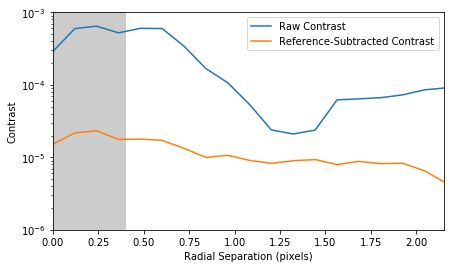

In [11]:
pix_scale = 0.032 # see https://jwst-docs.stsci.edu/display/JTI/NIRCam+Imaging
mask_radii = 0.4 # see https://jwst-docs.stsci.edu/display/JTI/NIRCam+Coronagraphic+Imaging

plt.figure(figsize=(7,4))
plt.semilogy(radial_bins * pix_scale,raw_contrast,label='Raw Contrast')
plt.semilogy(radial_bins * pix_scale,refsub_contrast,label='Reference-Subtracted Contrast')
plt.fill_between([0,mask_radii],1e-6,1e-3,color='k',alpha=0.2,lw=0)
plt.xlabel('Radial Separation (pixels)')
plt.ylabel('Contrast')
plt.xlim(0,2.15)
plt.ylim(1e-6,1e-3)
plt.legend(loc='upper right')